<a href="https://colab.research.google.com/github/TEhyeok/AIFFEL_Exploration/blob/main/DL_Master_MainQuest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목표 : 폐렴을 진단해보자!



## 데이터 설명
사용할 데이터는 캐글의 **Chest X-Ray Images** 입니다.

데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

(에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다.

### 폐렴이란?
폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.

출처 : https://ko.wikipedia.org/wiki/폐렴

### 염증이란?
염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.

출처 : https://ko.wikipedia.org/wiki/염증

## Set-up


In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/aiffel'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/content/drive/MyDrive/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/aiffel/chest_xray/train/NORMAL/NORMAL2-IM-0649-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/aiffel/chest_xray/train/PNEUMONIA/person622_bacteria_2494.jpeg


In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

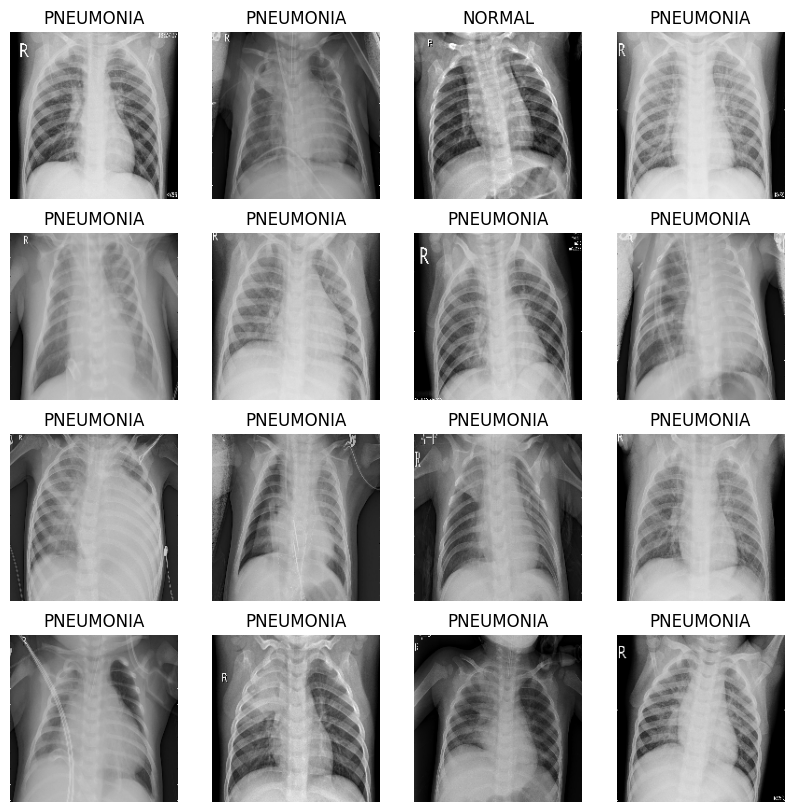

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
for images, labels in train_ds.take(1):
    print(images.dtype, labels.dtype)


<dtype: 'float32'> <dtype: 'bool'>


In [25]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return image, label

train_ds = train_ds.map(convert_types)
val_ds = val_ds.map(convert_types)

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 508s 2s/step - loss: 0.3863 - accuracy: 0.8211 - precision: 0.9613 - recall: 0.7914 - val_loss: 0.6276 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 413s 2s/step - loss: 0.2468 - accuracy: 0.9001 - precision: 0.9696 - recall: 0.8938 - val_loss: 1.2902 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 415s 2s/step - loss: 0.2196 - accuracy: 0.9116 - precision: 0.9747 - recall: 0.9048 - val_loss: 0.1537 - val_accuracy: 0.9433 - val_precision: 0.9302 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 422s 2s/step - loss: 0.1871 - accuracy: 0.9250 - precision: 0.9745 - recall: 0.9234 - val_loss: 1.4195 - val_accuracy: 0.5192 - val_precision: 1.0000 - val_recall: 0.3447
Epoch 5/10
261/261 [==============================] - 415s 2s/step - loss: 0.1735 - accuracy: 0.9370

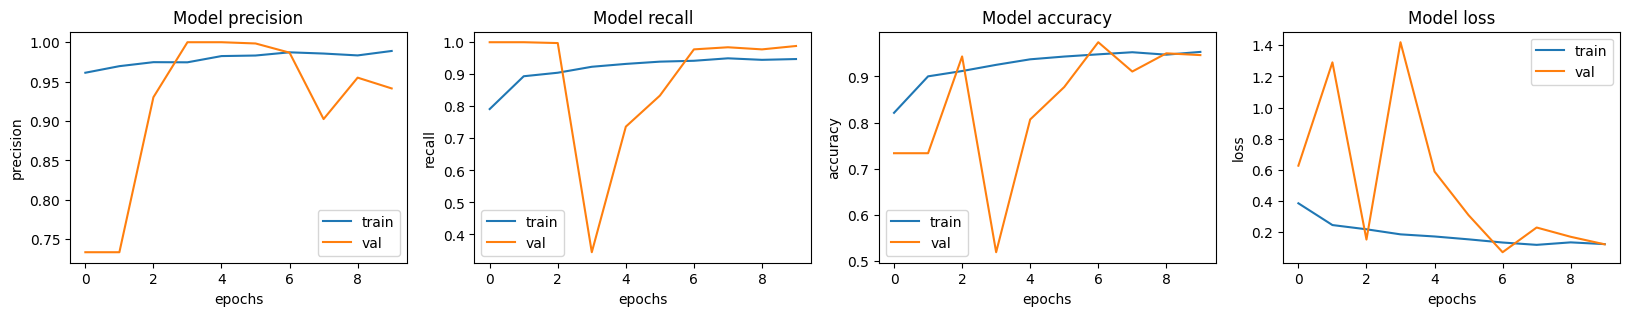

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 65s 2s/step - loss: 0.9126 - accuracy: 0.6971 - precision: 0.6742 - recall: 0.9974
Loss: 0.9126183986663818,
Accuracy: 0.6971153616905212,
Precision: 0.6741767525672913,
Recall: 0.9974358677864075
